In [1]:
import xarray as xr
import numpy as np
import os


In [2]:
combined_data=xr.open_dataset('/eos/jeodpp/data/projects/AGRI4CAST/MetStats/ozalp/AgERA5_BDAP/RR/AgERA5_1979_2023_rr.nc')

In [3]:
combined_data

<xarray.Dataset> Size: 14GB
Dimensions:             (time: 16436, lat: 400, lon: 550)
Coordinates:
  * time                (time) datetime64[ns] 131kB 1979-01-01 ... 2023-12-31
  * lon                 (lon) float64 4kB -9.9 -9.8 -9.7 -9.6 ... 44.8 44.9 45.0
  * lat                 (lat) float64 3kB 30.0 30.1 30.2 30.3 ... 69.7 69.8 69.9
Data variables:
    Precipitation_Flux  (time, lat, lon) float32 14GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    history:      Fri Mar 12 11:16:12 2021: cdo splitday /archive/ESG/wit015/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [4]:
subset_dsagera5 = combined_data.sel(lat=slice(30, 70), lon=slice(-10, 45), time=slice('1979-01-01', '2023-12-31'))


In [5]:
subset_dsagera5

<xarray.Dataset> Size: 14GB
Dimensions:             (time: 16436, lat: 400, lon: 550)
Coordinates:
  * time                (time) datetime64[ns] 131kB 1979-01-01 ... 2023-12-31
  * lon                 (lon) float64 4kB -9.9 -9.8 -9.7 -9.6 ... 44.8 44.9 45.0
  * lat                 (lat) float64 3kB 30.0 30.1 30.2 30.3 ... 69.7 69.8 69.9
Data variables:
    Precipitation_Flux  (time, lat, lon) float32 14GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    history:      Fri Mar 12 11:16:12 2021: cdo splitday /archive/ESG/wit015/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [6]:
subset_dsagera5

<xarray.Dataset> Size: 14GB
Dimensions:             (time: 16436, lat: 400, lon: 550)
Coordinates:
  * time                (time) datetime64[ns] 131kB 1979-01-01 ... 2023-12-31
  * lon                 (lon) float64 4kB -9.9 -9.8 -9.7 -9.6 ... 44.8 44.9 45.0
  * lat                 (lat) float64 3kB 30.0 30.1 30.2 30.3 ... 69.7 69.8 69.9
Data variables:
    Precipitation_Flux  (time, lat, lon) float32 14GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    history:      Fri Mar 12 11:16:12 2021: cdo splitday /archive/ESG/wit015/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [7]:
lat = np.where(subset_dsagera5.lat.values > 90, subset_dsagera5.lat.values - 90, subset_dsagera5.lat.values)
dsager = subset_dsagera5.assign_coords(lat=(["lat"], lat))
da = dsager.sortby('lat')
ds_reordered = da.transpose('time','lat', 'lon')

In [8]:
ds_reordered

<xarray.Dataset> Size: 14GB
Dimensions:             (time: 16436, lat: 400, lon: 550)
Coordinates:
  * time                (time) datetime64[ns] 131kB 1979-01-01 ... 2023-12-31
  * lon                 (lon) float64 4kB -9.9 -9.8 -9.7 -9.6 ... 44.8 44.9 45.0
  * lat                 (lat) float64 3kB 30.0 30.1 30.2 30.3 ... 69.7 69.8 69.9
Data variables:
    Precipitation_Flux  (time, lat, lon) float32 14GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    history:      Fri Mar 12 11:16:12 2021: cdo splitday /archive/ESG/wit015/...
    Conventions:  CF-1.7
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...

In [9]:
eobsv30=xr.open_dataset('/eos/jeodpp/data/projects/AGRI4CAST/MetStats/ozalp/EOBS_v30/rr_ens_mean_0.1deg_reg_v30.0e.nc')
mars25=xr.open_dataset('/eos/jeodpp/data/projects/AGRI4CAST/MetStats/ozalp/MARS_METEO/MARS_METEO_DB_v2024.02_corr.nc')


In [10]:
selected_data_eobsv30 = eobsv30.sel(latitude=slice(30, 70), longitude=slice(-10, 45), time=slice('1979-01-01', '2023-12-31'))


In [11]:
selected_data_mars25 = mars25.sel(lat=slice(30, 70), lon=slice(-10, 45), time=slice('1979-01-01', '2023-12-31'))
selected_data_mars25 = selected_data_mars25.rename({'lat': 'latitude', 'lon': 'longitude'})

In [12]:
print(selected_data_eobsv30.rr.dims)
print(selected_data_mars25.Rain.dims)
print(ds_reordered.Precipitation_Flux.dims)

('time', 'latitude', 'longitude')
('time', 'latitude', 'longitude')
('time', 'lat', 'lon')


In [13]:
print(selected_data_eobsv30.rr.size)
print(selected_data_mars25.Rain.size)
print(ds_reordered.Precipitation_Flux.size)

3615920000
359246664
3615920000


In [14]:

import dask.array as da


ds_reordered = ds_reordered.chunk({'time': -1})  

subset_dsagera5_aligned_eobsv30 = ds_reordered.Precipitation_Flux.sel(
    lat=selected_data_eobsv30.latitude,
    lon=selected_data_eobsv30.longitude,
    time=selected_data_eobsv30.time,
    method='nearest'
)

subset_dsagera5_aligned_mars25 = ds_reordered.Precipitation_Flux.sel(
    lat=selected_data_mars25.latitude,
    lon=selected_data_mars25.longitude,
    time=selected_data_mars25.time,
    method='nearest'
)

bias_eobsv30 = (selected_data_eobsv30.rr - subset_dsagera5_aligned_eobsv30).compute()
bias_mars25 = (selected_data_mars25.Rain - subset_dsagera5_aligned_mars25).compute()

In [15]:
print('Resolution EOBSv30 v AgERA5:',subset_dsagera5_aligned_eobsv30.rio.resolution(),selected_data_eobsv30.rio.resolution())


Resolution EOBSv30 v AgERA5: (0.09999999959995305, 0.09999999557312493) (0.09999999959995305, 0.09999999557312493)


In [16]:
print('Resolution MARS_25 v AgERA5:',subset_dsagera5_aligned_mars25.rio.resolution(),selected_data_mars25.rio.resolution())


Resolution MARS_25 v AgERA5: (0.317621, 0.317621) (0.317621, 0.317621)


In [17]:
mean_bias_eobsv30 = bias_eobsv30.mean(dim=('latitude', 'longitude'))

mean_bias_mars25 = bias_mars25.mean(dim=('latitude', 'longitude'))

In [18]:
corr_bias_agera_vs_eobsv30=subset_dsagera5_aligned_eobsv30+mean_bias_eobsv30

corr_bias_agera_vs_mars25=subset_dsagera5_aligned_mars25+mean_bias_mars25

In [19]:
monthly_row_agera5 = ds_reordered['Precipitation_Flux'].resample(time='ME', skipna=True).mean()
monthly_ref_eobsv30 = selected_data_eobsv30['rr'].resample(time='ME',skipna=True).mean()
monthly_ref_mars25 = selected_data_mars25['Rain'].resample(time='ME',skipna=True).mean()
monthly_bias_eobsv30 = corr_bias_agera_vs_eobsv30.resample(time='ME',skipna=True).mean()
monthly_bias_mars25 = corr_bias_agera_vs_mars25.resample(time='ME',skipna=True).mean()

In [20]:
monthly_ref_mean_eobsv30 = monthly_ref_eobsv30.mean(dim=('longitude', 'latitude'))
monthly_row_mean_agera5 = monthly_row_agera5.mean(dim=('lon', 'lat'))
monthly_bias_mean_eobsv30 = monthly_bias_eobsv30 .mean(dim=('longitude', 'latitude'))

In [21]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Monthly time series of Precipitations (1979-2023) @ EU EOBS_v30 v AgERA5_v1 v AgERA5_v1-BIAS')

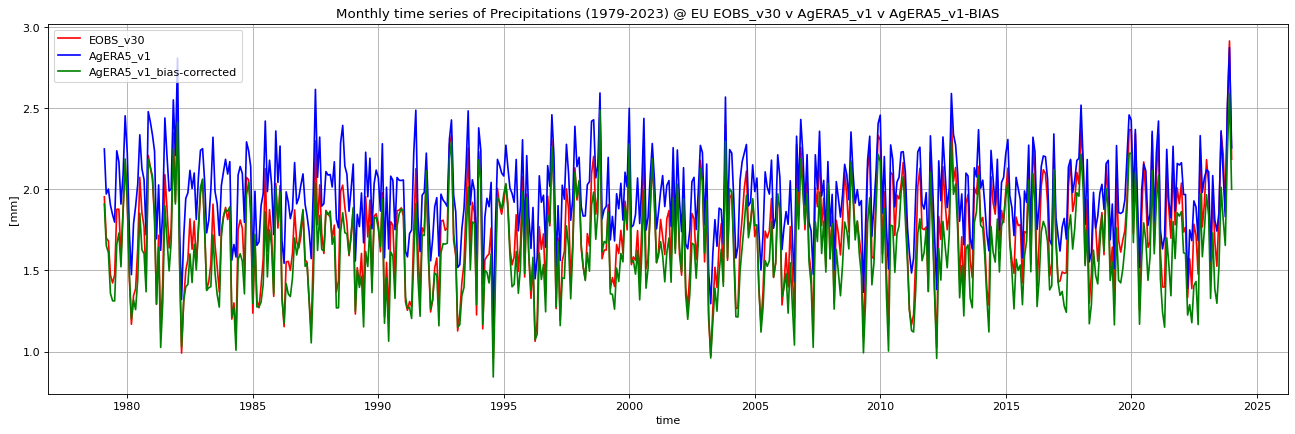

In [22]:
figure(figsize=(20, 6), dpi=80)
monthly_ref_mean_eobsv30.plot(color='r') #eobs
monthly_row_mean_agera5.plot(color='b') #agera
monthly_bias_mean_eobsv30.plot(color='g') #ageraBias
plt.ylabel('[mm]')
plt.grid()
plt.legend (['EOBS_v30', 'AgERA5_v1','AgERA5_v1_bias-corrected'],loc = 'upper left')
plt.title('Monthly time series of Precipitations (1979-2023) @ EU EOBS_v30 v AgERA5_v1 v AgERA5_v1-BIAS',fontsize= '12')

In [23]:
monthly_ref_mean_mars25 = monthly_ref_mars25.mean(dim=('longitude', 'latitude'))
monthly_row_mean_agera5 = monthly_row_agera5.mean(dim=('lon', 'lat'))
monthly_bias_mean_mars25 = monthly_bias_mars25 .mean(dim=('longitude', 'latitude'))

Text(0.5, 1.0, 'Monthly time series of Precipitations (1979-2023) @ EU MARS25 v AgERA5_v1 v AgERA5_v1-BIAS')

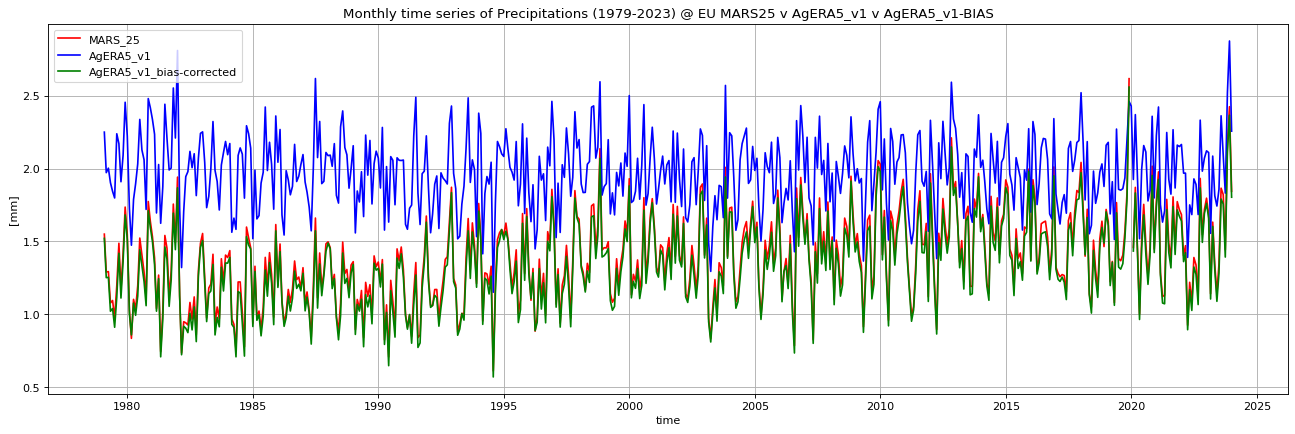

In [24]:
figure(figsize=(20, 6), dpi=80)
monthly_ref_mean_mars25.plot(color='r') #eobs
monthly_row_mean_agera5.plot(color='b') #agera
monthly_bias_mean_mars25.plot(color='g') #ageraBias
plt.ylabel('[mm]')
plt.grid()
plt.legend (['MARS_25', 'AgERA5_v1','AgERA5_v1_bias-corrected'],loc = 'upper left')
plt.title('Monthly time series of Precipitations (1979-2023) @ EU MARS25 v AgERA5_v1 v AgERA5_v1-BIAS',fontsize= '12')

In [25]:
seasonal_ref_eobsv30 = selected_data_eobsv30['rr'].groupby(selected_data_eobsv30["time"].dt.month).mean()
seasonal_row_t = ds_reordered['Precipitation_Flux'].groupby(ds_reordered["time"].dt.month).mean()
seasonal_bias_eobsv30 = corr_bias_agera_vs_eobsv30.groupby(corr_bias_agera_vs_eobsv30["time"].dt.month).mean()

In [26]:
seasonal_ref_eobsv30 = seasonal_ref_eobsv30.mean(dim=('longitude', 'latitude'))
seasonal_row_mean_t = seasonal_row_t.mean(dim=('lon', 'lat'))
seasonal_bias_mean_eobsv30 = seasonal_bias_eobsv30.mean(dim=('longitude', 'latitude'))

Text(0.5, 1.0, 'Annual cycle of monthly Precipitations (1979-2023) @ EU EOBS_v30 v AgERA5_v1 v AgERA5_v1-BIAS')

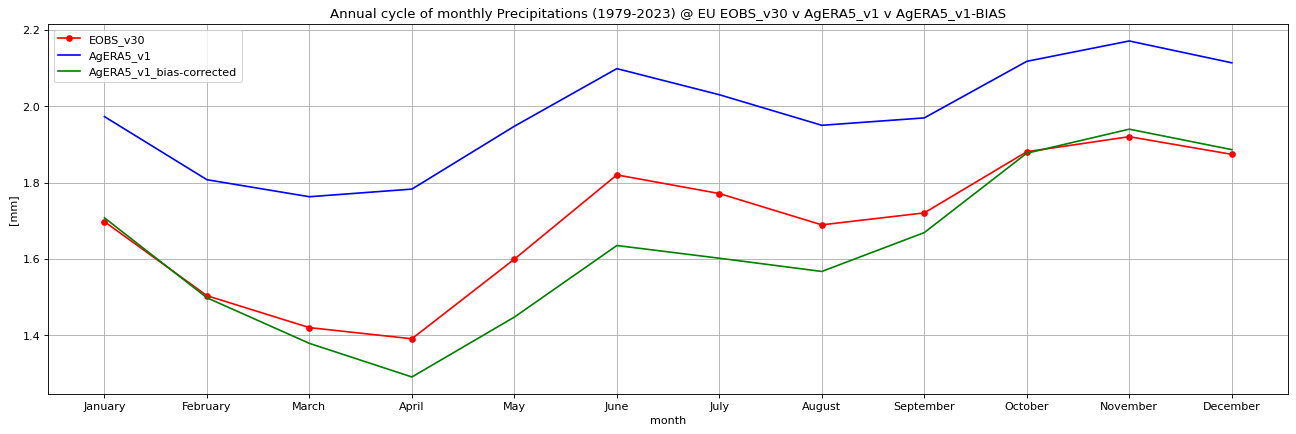

In [27]:
figure(figsize=(20, 6), dpi=80)
seasonal_ref_eobsv30.plot (color='r', marker=".", markersize=10)
seasonal_row_mean_t.plot(color='b')
seasonal_bias_mean_eobsv30.plot(color='g')
plt.xlabel('month')
plt.ylabel('[mm]')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],['January', 'February', 'March','April','May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.grid()
plt.legend (['EOBS_v30', 'AgERA5_v1','AgERA5_v1_bias-corrected'])
plt.title('Annual cycle of monthly Precipitations (1979-2023) @ EU EOBS_v30 v AgERA5_v1 v AgERA5_v1-BIAS')

In [28]:
seasonal_ref_mars25 = selected_data_mars25['Rain'].groupby(selected_data_mars25["time"].dt.month).mean()
seasonal_row_t = ds_reordered['Precipitation_Flux'].groupby(ds_reordered["time"].dt.month).mean()
seasonal_bias_mars25 = corr_bias_agera_vs_mars25.groupby(corr_bias_agera_vs_mars25["time"].dt.month).mean()

In [29]:
seasonal_ref_mars25 = seasonal_ref_mars25.mean(dim=('longitude', 'latitude'))
seasonal_row_mean_t = seasonal_row_t.mean(dim=('lon', 'lat'))
seasonal_bias_mean_mars25 = seasonal_bias_mars25.mean(dim=('longitude', 'latitude'))

Text(0.5, 1.0, 'Annual cycle of monthly Precipitations (1979-2023) @ EU MARS_25 v AgERA5_v1 v AgERA5_v1-BIAS')

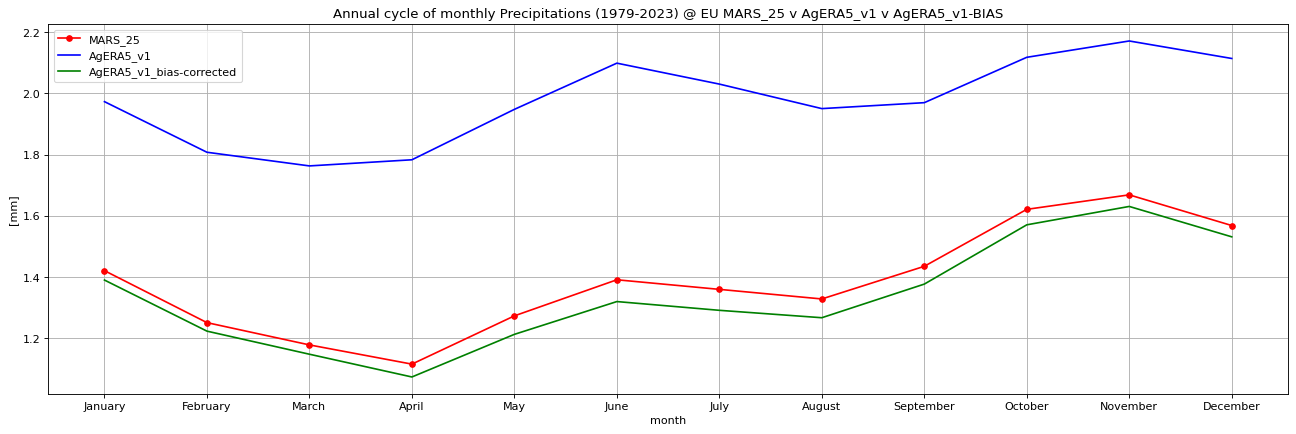

In [30]:
figure(figsize=(20, 6), dpi=80)
seasonal_ref_mars25.plot (color='r', marker=".", markersize=10)
seasonal_row_mean_t.plot(color='b')
seasonal_bias_mean_mars25.plot(color='g')
plt.xlabel('month')
plt.ylabel('[mm]')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],['January', 'February', 'March','April','May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.grid()
plt.legend (['MARS_25', 'AgERA5_v1','AgERA5_v1_bias-corrected'])
plt.title('Annual cycle of monthly Precipitations (1979-2023) @ EU MARS_25 v AgERA5_v1 v AgERA5_v1-BIAS')

In [31]:
mean_ref_eobsv30 =selected_data_eobsv30['rr'].resample(time='YE',skipna=True).mean()
mean_row_t =ds_reordered['Precipitation_Flux'].resample(time='YE',skipna=True).mean()
mean_bias_eobsv30 =corr_bias_agera_vs_eobsv30.resample(time='YE',skipna=True).mean()

mean_ref_eobsv30 = mean_ref_eobsv30.mean(dim='time')
mean_row_t = mean_row_t.mean(dim='time')
mean_bias_eobsv30 = mean_bias_eobsv30.mean(dim='time')

In [35]:
mean_ref_mars25 =selected_data_mars25['Rain'].resample(time='YE',skipna=True).mean()
mean_row_t =ds_reordered['Precipitation_Flux'].resample(time='YE',skipna=True).mean()
mean_bias_mars25 =corr_bias_agera_vs_mars25.resample(time='YE',skipna=True).mean()

mean_ref_mars25 = mean_ref_mars25.mean(dim='time')
mean_row_t = mean_row_t.mean(dim='time')
mean_bias_mars25 = mean_bias_mars25.mean(dim='time')

In [36]:
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.feature as cf

Text(0.5, 1.0, 'EOBS_v30 annual average total precipitation (1979-2023)')

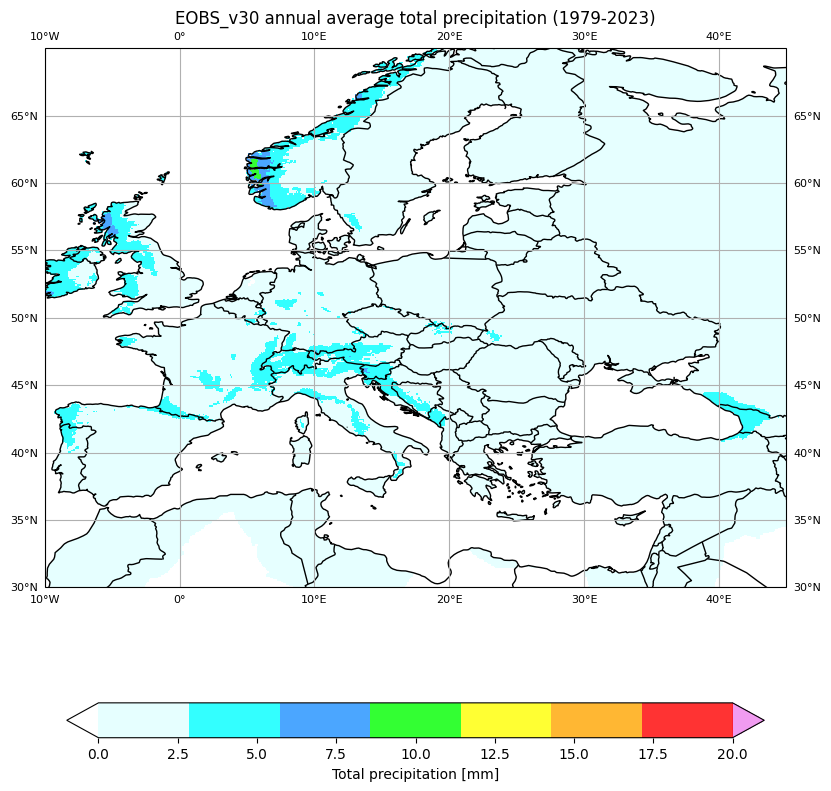

In [37]:
fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())
lons = mean_ref_eobsv30.longitude.values
lats = mean_ref_eobsv30.latitude.values
data = mean_ref_eobsv30.squeeze()
g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 8, 'color': 'k'}
g1.ylabel_style = {'size': 8, 'color': 'k'}
cmap_prec = mpl.colors.ListedColormap(['lightcyan','cyan','dodgerblue','lime', 'yellow','orange','red']) 
cmap_prec.set_over('violet')
cmap_prec.set_under('white')
im=ax.pcolormesh(lons, lats , data, shading='auto',
              alpha=0.8, cmap=cmap_prec,antialiased=True, linewidth=0.5,vmin= 0, vmax=20)
cbar = fig.colorbar(im, extend='both', shrink=0.5, ax=ax,orientation= 'horizontal')#,ticklocation= 'bottom')
cbar.set_label('Total precipitation [mm]')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
#ax.set_xlim([2, 25])
#ax.set_ylim([32.5, 50.])
plt.title('EOBS_v30 annual average total precipitation (1979-2023)',fontsize= '12')

Text(0.5, 1.0, 'MARS_25 annual average total precipitation (1979-2023)')

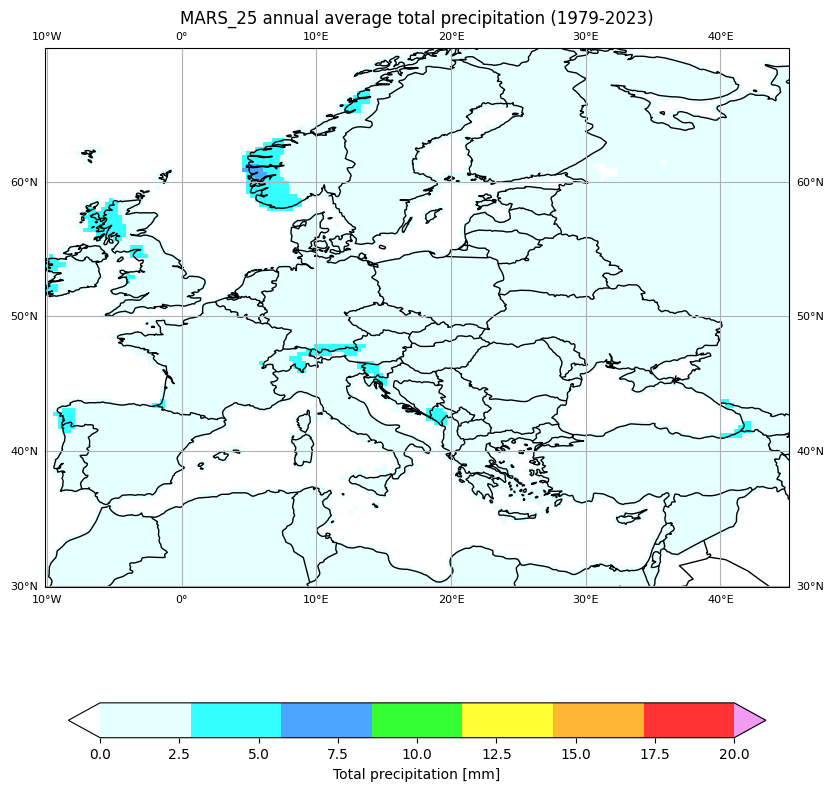

In [38]:
fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())
lons = mean_ref_mars25.longitude.values
lats = mean_ref_mars25.latitude.values
data = mean_ref_mars25.squeeze()
g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 8, 'color': 'k'}
g1.ylabel_style = {'size': 8, 'color': 'k'}
cmap_prec = mpl.colors.ListedColormap(['lightcyan','cyan','dodgerblue','lime', 'yellow','orange','red']) 
cmap_prec.set_over('violet')
cmap_prec.set_under('white')
im=ax.pcolormesh(lons, lats , data, shading='auto',
              alpha=0.8, cmap=cmap_prec,antialiased=True, linewidth=0.5,vmin= 0, vmax=20)
cbar = fig.colorbar(im, extend='both', shrink=0.5, ax=ax,orientation= 'horizontal')#,ticklocation= 'bottom')
cbar.set_label('Total precipitation [mm]')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
#ax.set_xlim([2, 25])
#ax.set_ylim([32.5, 50.])
plt.title('MARS_25 annual average total precipitation (1979-2023)',fontsize= '12')

Text(0.5, 1.0, 'AgERA5 annual average total precipitation (1979-2023)')

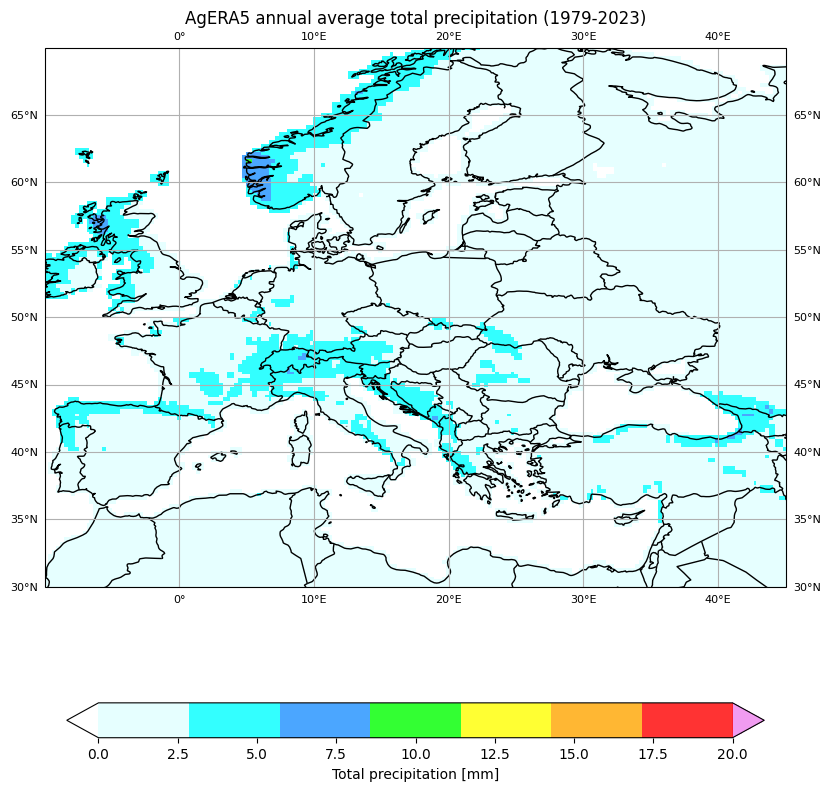

In [39]:
fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())
lons = mean_row_t.lon.values
lats = mean_row_t.lat.values
data = mean_row_t.squeeze()
g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 8, 'color': 'k'}
g1.ylabel_style = {'size': 8, 'color': 'k'}
cmap_prec = mpl.colors.ListedColormap(['lightcyan','cyan','dodgerblue','lime', 'yellow','orange','red']) 
cmap_prec.set_over('violet')
cmap_prec.set_under('white')
im=ax.pcolormesh(lons, lats , data, shading='auto',
              alpha=0.8, cmap=cmap_prec,antialiased=True, linewidth=0.5,vmin= 0, vmax=20)
cbar = fig.colorbar(im, extend='both', shrink=0.5, ax=ax,orientation= 'horizontal')#,ticklocation= 'bottom')
cbar.set_label('Total precipitation [mm]')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
#ax.set_xlim([2, 25])
#ax.set_ylim([32.5, 50.])
plt.title('AgERA5 annual average total precipitation (1979-2023)',fontsize= '12')

Text(0.5, 1.0, 'AgERA5_v1_bias-corrected v EOBS_v30 annual average total precipitation (1979-2023)')

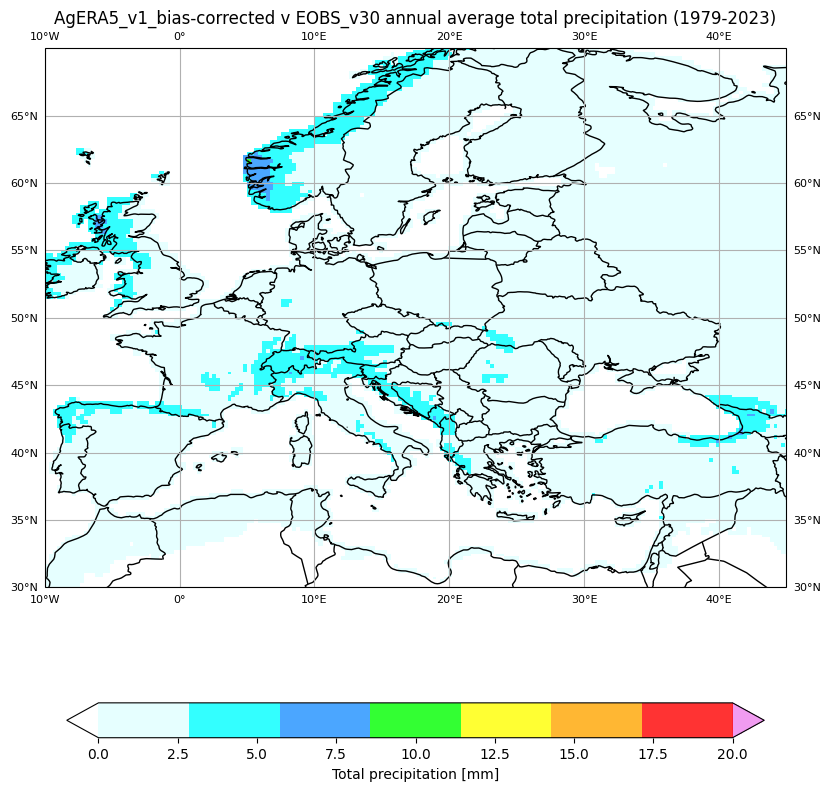

In [40]:
fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())
lons = mean_bias_eobsv30.longitude.values
lats = mean_bias_eobsv30.latitude.values
data = mean_bias_eobsv30.squeeze()
g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 8, 'color': 'k'}
g1.ylabel_style = {'size': 8, 'color': 'k'}
cmap_prec = mpl.colors.ListedColormap(['lightcyan','cyan','dodgerblue','lime', 'yellow','orange','red']) 
cmap_prec.set_over('violet')
cmap_prec.set_under('white')
im=ax.pcolormesh(lons, lats , data, shading='auto',
              alpha=0.8, cmap=cmap_prec,antialiased=True, linewidth=0.5,vmin= 0, vmax=20)
cbar = fig.colorbar(im, extend='both', shrink=0.5, ax=ax,orientation= 'horizontal')#,ticklocation= 'bottom')
cbar.set_label('Total precipitation [mm]')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
#ax.set_xlim([2, 25])
#ax.set_ylim([32.5, 50.])
plt.title('AgERA5_v1_bias-corrected v EOBS_v30 annual average total precipitation (1979-2023)',fontsize= '12')

Text(0.5, 1.0, 'AgERA5_v1_bias-corrected v MARS_25 annual average total precipitation (1979-2023)')

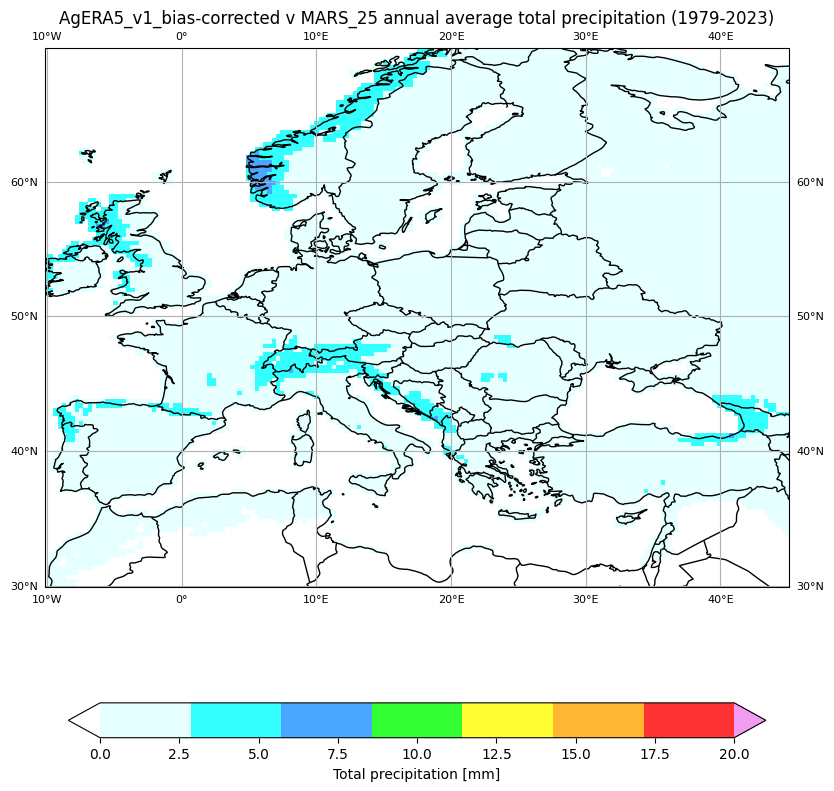

In [41]:
fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())
lons = mean_bias_mars25.longitude.values
lats = mean_bias_mars25.latitude.values
data = mean_bias_mars25.squeeze()
g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 8, 'color': 'k'}
g1.ylabel_style = {'size': 8, 'color': 'k'}
cmap_prec = mpl.colors.ListedColormap(['lightcyan','cyan','dodgerblue','lime', 'yellow','orange','red']) 
cmap_prec.set_over('violet')
cmap_prec.set_under('white')
im=ax.pcolormesh(lons, lats , data, shading='auto',
              alpha=0.8, cmap=cmap_prec,antialiased=True, linewidth=0.5,vmin= 0, vmax=20)
cbar = fig.colorbar(im, extend='both', shrink=0.5, ax=ax,orientation= 'horizontal')#,ticklocation= 'bottom')
cbar.set_label('Total precipitation [mm]')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
#ax.set_xlim([2, 25])
#ax.set_ylim([32.5, 50.])
plt.title('AgERA5_v1_bias-corrected v MARS_25 annual average total precipitation (1979-2023)',fontsize= '12')